# Analyse einer PV-Anlage

Dieses Notebook analysiert die Produktions- und Verbrauchsdaten einer Photovoltaik-Anlage. Es werden folgende Aspekte untersucht:

- Tägliche Energieproduktion und Verbrauch
- Durchschnittlicher Tagesverlauf
- Analyse der Eigenversorgung und Energiebilanz

## Daten importieren und vorbereiten

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import requests


### Daten einlesen
Wir lesen die Daten aus drei CSV-Dateien (A.csv, B.csv, C.csv) und führen sie zusammen.

In [3]:
# Daten einlesen
df_a = pd.read_csv('data/A.csv', parse_dates=['Timestamp'])
df_b = pd.read_csv('data/B.csv', parse_dates=['Timestamp'])
df_c = pd.read_csv('data/C.csv', parse_dates=['Timestamp'])

# Daten zusammenführen
dfs = [df_a, df_b, df_c]
df = pd.concat(dfs, axis=0)
df = df.sort_values('Timestamp').reset_index(drop=True)

# Zeige die ersten Zeilen des zusammengeführten Datensatzes
df.head()


,Timestamp,Generation_kW,Grid_Feed-In_kW,Grid_Supply_kW,Overall_Consumption_Calc_kW
0,2019-01-01 00:00:00,0.0,0.0,4.212,4.212
1,2019-01-01 00:00:00,NaN,0.0,2.800,NaN
2,2019-01-01 00:00:00,0.0,0.0,5.400,5.400
3,2019-01-01 00:15:00,0.0,0.0,4.212,4.212
4,2019-01-01 00:15:00,NaN,0.0,2.800,NaN


### Tägliche Summen berechnen
Wir aggregieren die Daten auf Tagesebene, um die täglichen Summen für Produktion und Verbrauch zu analysieren.

In [4]:
# Tägliche Summen berechnen
df['Date'] = df['Timestamp'].dt.date
daily_sums = df.groupby('Date').agg({
    'Generation_kW': 'sum',
    'Grid_Supply_kW': 'sum',
    'Grid_Feed-In_kW': 'sum',
    'Overall_Consumption_Calc_kW': 'sum'
}).reset_index()

daily_sums.head()


,Date,Generation_kW,Grid_Supply_kW,Grid_Feed-In_kW,Overall_Consumption_Calc_kW
0,2019-01-01,368.560,1278.776,155.312,1088.024
1,2019-01-02,886.412,1059.700,534.504,1109.208
2,2019-01-03,931.004,1502.120,345.040,1804.284
3,2019-01-04,1007.944,1609.452,319.040,1947.356
4,2019-01-05,9.048,1231.536,0.000,1016.184


## Visualisierungen

### 1. Tägliche Energieproduktion vs. Verbrauch

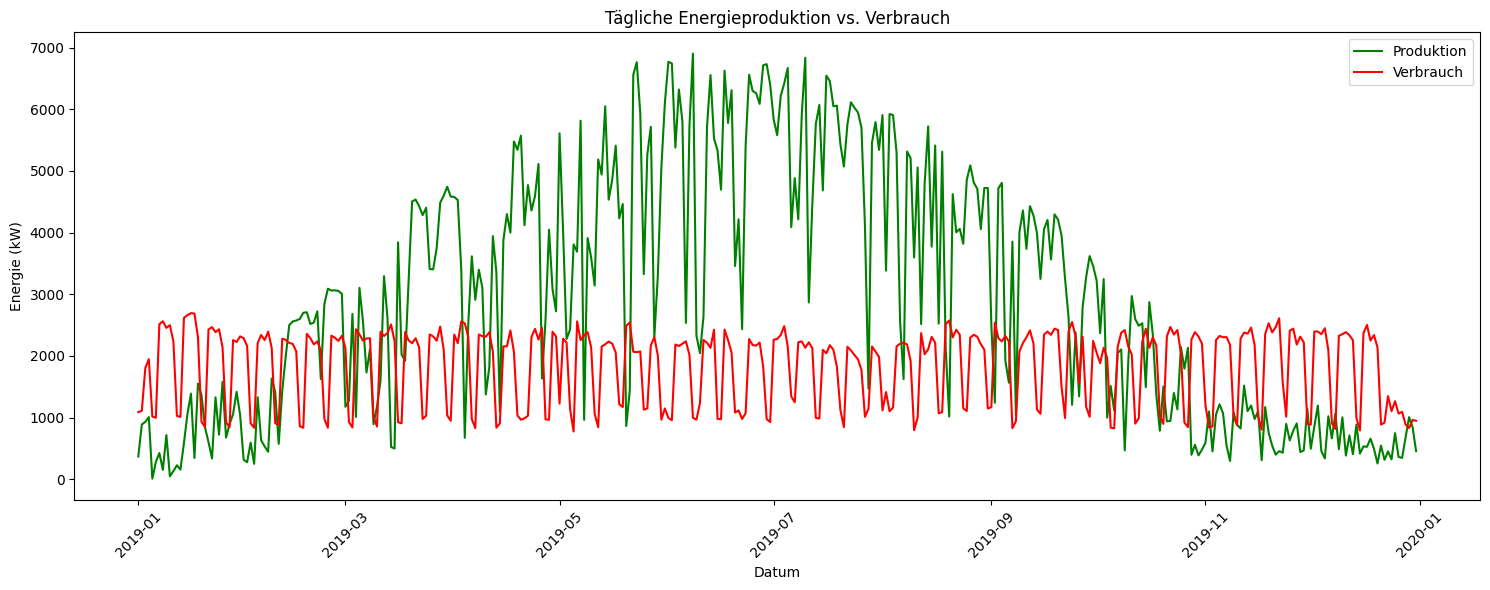

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sums['Date'], daily_sums['Generation_kW'], label='Produktion', color='green')
plt.plot(daily_sums['Date'], daily_sums['Overall_Consumption_Calc_kW'], label='Verbrauch', color='red')
plt.title('Tägliche Energieproduktion vs. Verbrauch')
plt.xlabel('Datum')
plt.ylabel('Energie (kW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()


### 2. Durchschnittlicher Tagesverlauf
Dieser Plot zeigt den durchschnittlichen Verlauf von Produktion und Verbrauch über einen Tag.

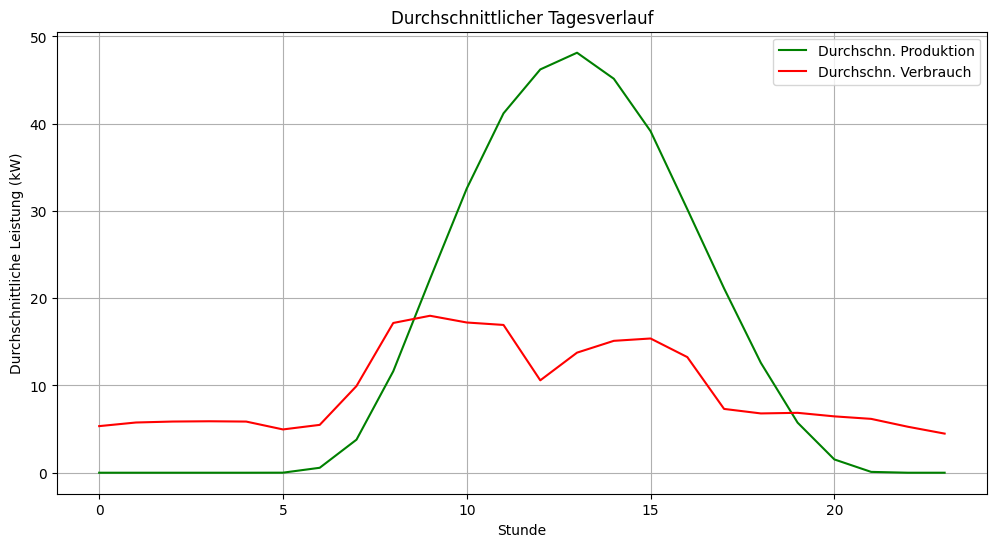

In [13]:
# Durchschnittlichen Tagesverlauf berechnen
df['Hour'] = df['Timestamp'].dt.hour
hourly_avg = df.groupby('Hour').agg({
    'Generation_kW': 'mean',
    'Overall_Consumption_Calc_kW': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg['Hour'], hourly_avg['Generation_kW'], label='Durchschn. Produktion', color='green')
plt.plot(hourly_avg['Hour'], hourly_avg['Overall_Consumption_Calc_kW'], label='Durchschn. Verbrauch', color='red')
plt.title('Durchschnittlicher Tagesverlauf')
plt.xlabel('Stunde')
plt.ylabel('Durchschnittliche Leistung (kW)')
plt.legend()
plt.grid(True)


## Analyse der Eigenversorgung
Wir untersuchen, an wie vielen Tagen die Eigenproduktion den Verbrauch decken konnte und berechnen die Gesamtenergiebilanz.

In [14]:
# Analyse der Eigenversorgung
daily_sums['self_sufficient'] = daily_sums['Generation_kW'] >= daily_sums['Overall_Consumption_Calc_kW']
self_sufficient_days = daily_sums['self_sufficient'].sum()
total_days = len(daily_sums)

print(f"Analyseergebnisse:")
print(f"Gesamtzahl der Tage: {total_days}")
print(f"Tage mit ausreichender Eigenproduktion: {self_sufficient_days}")
print(f"Prozentsatz der Tage mit Eigenversorgung: {(self_sufficient_days/total_days)*100:.2f}%")

# Energiebilanz
total_production = daily_sums['Generation_kW'].sum()
total_consumption = daily_sums['Overall_Consumption_Calc_kW'].sum()
print(f"\nGesamtproduktion: {total_production:.2f} kW")
print(f"Gesamtverbrauch: {total_consumption:.2f} kW")
print(f"Energiebilanz: {((total_production/total_consumption)*100):.2f}% des Verbrauchs wird durch Eigenproduktion gedeckt")


Analyseergebnisse:
Gesamtzahl der Tage: 365
Tage mit ausreichender Eigenproduktion: 229
Prozentsatz der Tage mit Eigenversorgung: 62.74%

Gesamtproduktion: 1056566.47 kW
Gesamtverbrauch: 671094.26 kW
Energiebilanz: 157.44% des Verbrauchs wird durch Eigenproduktion gedeckt


# TSM Plot (Sandra)

c:\PV_Optimization\PV-Optimisation\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\PV_Optimization\PV-Optimisation\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


=== Modell: Produktion ===
                       ExponentialSmoothing Model Results                       
Dep. Variable:            Generation_kW   No. Observations:                  365
Model:             ExponentialSmoothing   SSE                      451708815.230
Optimized:                         True   AIC                           5128.458
Trend:                         Additive   BIC                           5144.057
Seasonal:                          None   AICC                          5128.692
Seasonal Periods:                  None   Date:                 Tue, 20 May 2025
Box-Cox:                          False   Time:                         19:04:25
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2385461                alpha                 True
smoothi

<module 'matplotlib.pyplot' from 'c:\\PV_Optimization\\PV-Optimisation\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

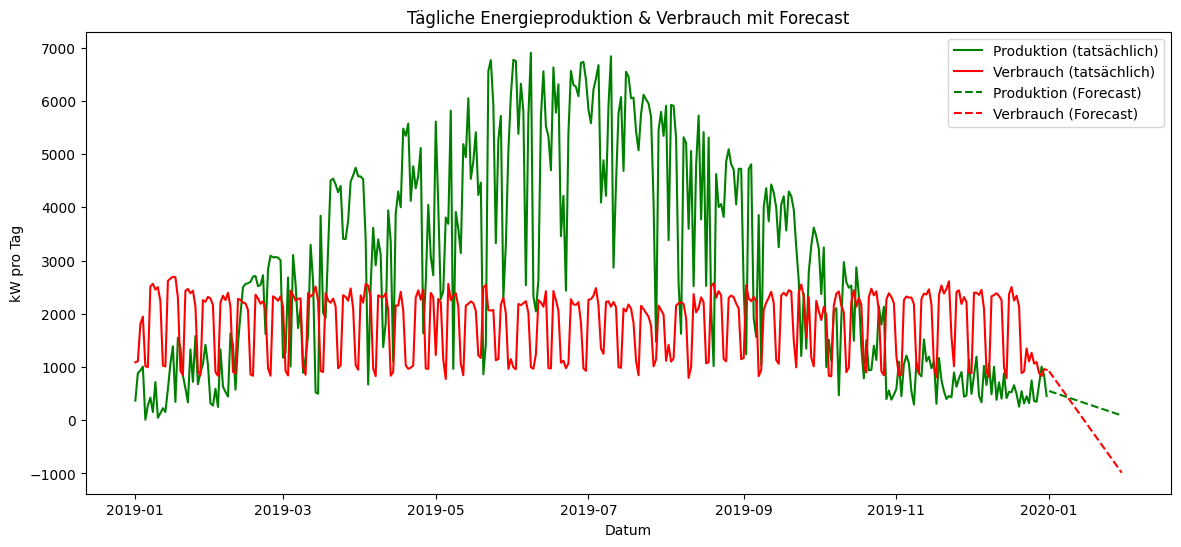

In [5]:
# === Kopie von daily_sums, Index & Frequenz setzen ===
daily = daily_sums.copy()
daily['Date'] = pd.to_datetime(daily['Date'])   # sicherstellen, dass DateTime-Objekte vorliegen
daily.set_index('Date', inplace=True)           # Date-Spalte als Index
daily = daily.asfreq('D')                       # tägliche Frequenz für saubere Zeitreihe
# optional: fehlende Tage auffüllen
# daily.fillna(0, inplace=True)

# === Holt-Winters Modell: Produktion (ohne Saisonalität) ===
model_prod = ExponentialSmoothing(
    daily['Generation_kW'],
    trend='add',
    seasonal=None
).fit()
forecast_prod = model_prod.forecast(30)

print("=== Modell: Produktion ===")
print(model_prod.summary())

# === Holt-Winters Modell: Verbrauch (ohne Saisonalität) ===
model_cons = ExponentialSmoothing(
    daily['Overall_Consumption_Calc_kW'],
    trend='add',
    seasonal=None
).fit()
forecast_cons = model_cons.forecast(30)

print("\n=== Modell: Verbrauch ===")
print(model_cons.summary())

# === Plot: Tatsächlich + Forecast ===
plt.figure(figsize=(14, 6))
plt.plot(daily['Generation_kW'], color='green', label='Produktion (tatsächlich)')
plt.plot(daily['Overall_Consumption_Calc_kW'], color='red', label='Verbrauch (tatsächlich)')
plt.plot(forecast_prod,      'g--',       label='Produktion (Forecast)')
plt.plot(forecast_cons,      'r--',       label='Verbrauch (Forecast)')
plt.title('Tägliche Energieproduktion & Verbrauch mit Forecast')
plt.xlabel('Datum')
plt.ylabel('kW pro Tag')
plt.legend()
plt


# Deckungsgrad

C:\Users\s.deck\AppData\Local\Temp\ipykernel_48380\62323445.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily['Deckungsgrad'].replace([np.inf, -np.inf], np.nan, inplace=True)


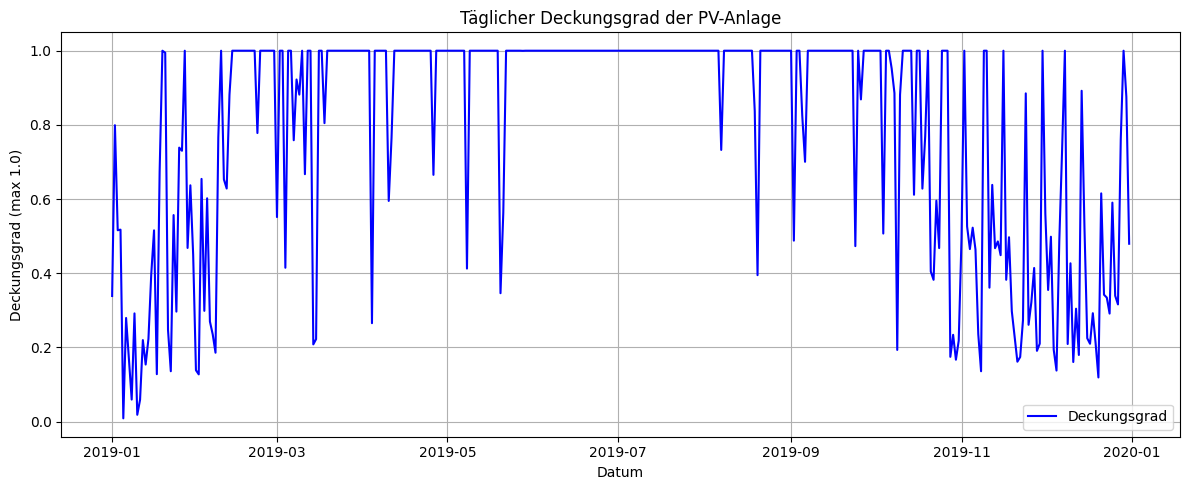

In [7]:
# Deckungsgrad berechnen (unter Verwendung der vorhandenen Spalten)
daily['Deckungsgrad'] = daily['Generation_kW'] / daily['Overall_Consumption_Calc_kW']

# Inf und -Inf (durch Division durch 0) in NaN umwandeln
daily['Deckungsgrad'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Deckungsgrad > 1 auf 1 begrenzen (100 % Autarkie)
daily['Deckungsgrad'] = daily['Deckungsgrad'].clip(upper=1)

# Optional: NaNs auf 0 setzen, falls gewünscht
# daily['Deckungsgrad'].fillna(0, inplace=True)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(daily.index, daily['Deckungsgrad'], color='blue', label='Deckungsgrad')
plt.title('Täglicher Deckungsgrad der PV-Anlage')
plt.xlabel('Datum')
plt.ylabel('Deckungsgrad (max 1.0)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# TSM Plot (Sandra)

# Verlustleistung messen (Abi)

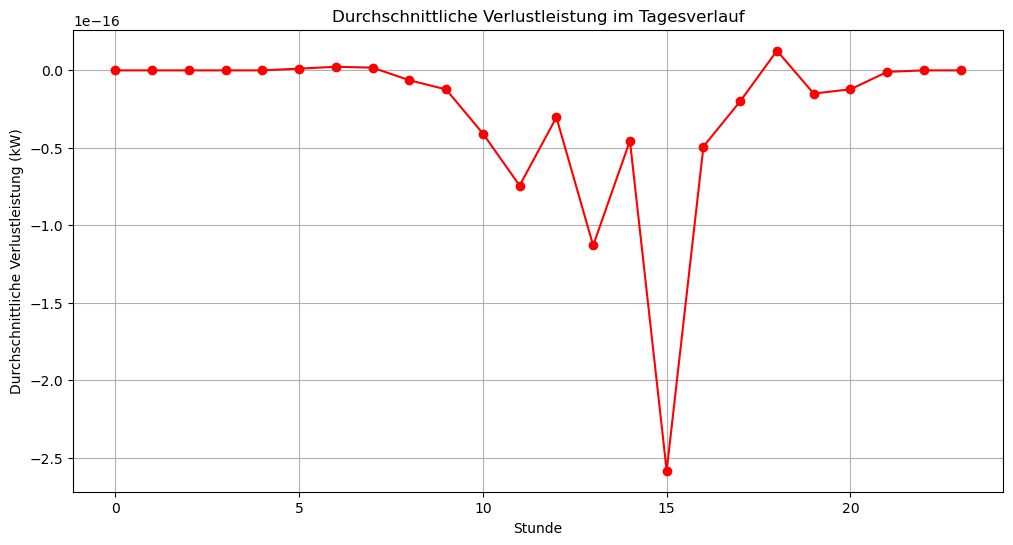


Statistik der Verlustleistung:
Durchschnittliche Verlustleistung: -0.00 kW
Maximale Verlustleistung: 0.00 kW
Gesamtverlust: -0.00 kW


In [ ]:
# Berechnung der Verlustleistung
df['Local_Consumption_kW'] = df['Overall_Consumption_Calc_kW'] - df['Grid_Supply_kW']
df['Power_Loss_kW'] = df['Generation_kW'] - df['Grid_Feed-In_kW'] - df['Local_Consumption_kW']

# Durchschnittliche Verluste pro Stunde
hourly_losses = df.groupby(df['Timestamp'].dt.hour)['Power_Loss_kW'].mean()

# Visualisierung der durchschnittlichen Verluste im Tagesverlauf
plt.figure(figsize=(12, 6))
plt.plot(hourly_losses.index, hourly_losses.values, color='red', marker='o')
plt.title('Durchschnittliche Verlustleistung im Tagesverlauf')
plt.xlabel('Stunde')
plt.ylabel('Durchschnittliche Verlustleistung (kW)')
plt.grid(True)
plt.show()

# Gesamtstatistik der Verluste
total_loss = df['Power_Loss_kW'].sum()
avg_loss = df['Power_Loss_kW'].mean()
max_loss = df['Power_Loss_kW'].max()

print(f'\nStatistik der Verlustleistung:')
print(f'Durchschnittliche Verlustleistung: {avg_loss:.2f} kW')
print(f'Maximale Verlustleistung: {max_loss:.2f} kW')
print(f'Gesamtverlust: {total_loss:.2f} kW')


### Analyse der Verlustleistung in Abhängigkeit von Produktion und Temperatur
Nachfolgend analysieren wir:
1. Den Zusammenhang zwischen Produktionsleistung und Verlustleistung (Wechselrichtereffizienz)
2. Den Einfluss der Außentemperatur auf die Verlustleistung

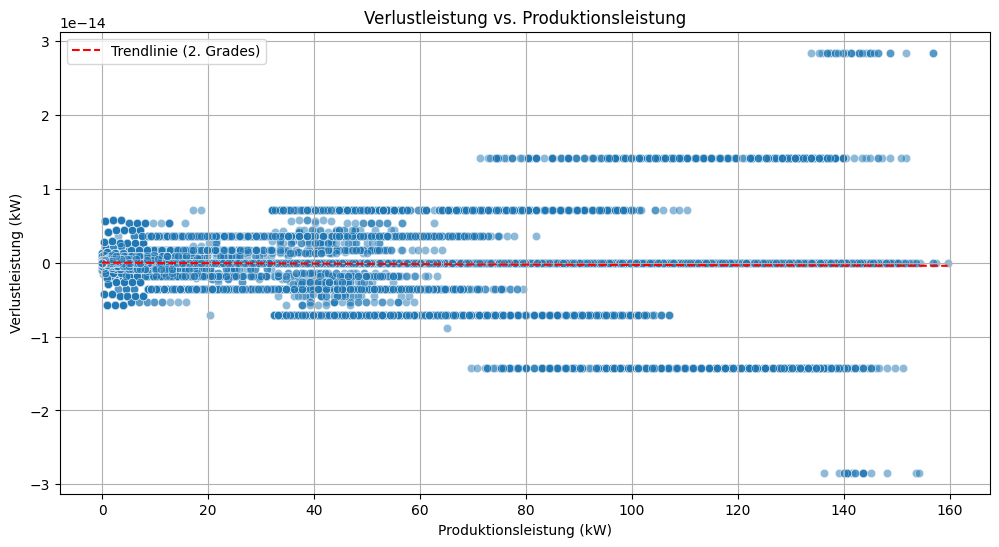


Effizienzanalyse nach Leistungsbereich:
             Loss_Ratio_Mean  Generation_kW_Mean  Count
Power_Range                                            
0-20%                   -0.0               4.350  58756
20-40%                  -0.0              42.733   5901
40-60%                  -0.0              79.490   2400
60-80%                  -0.0             111.684   2194
80-100%                 -0.0             136.335    829


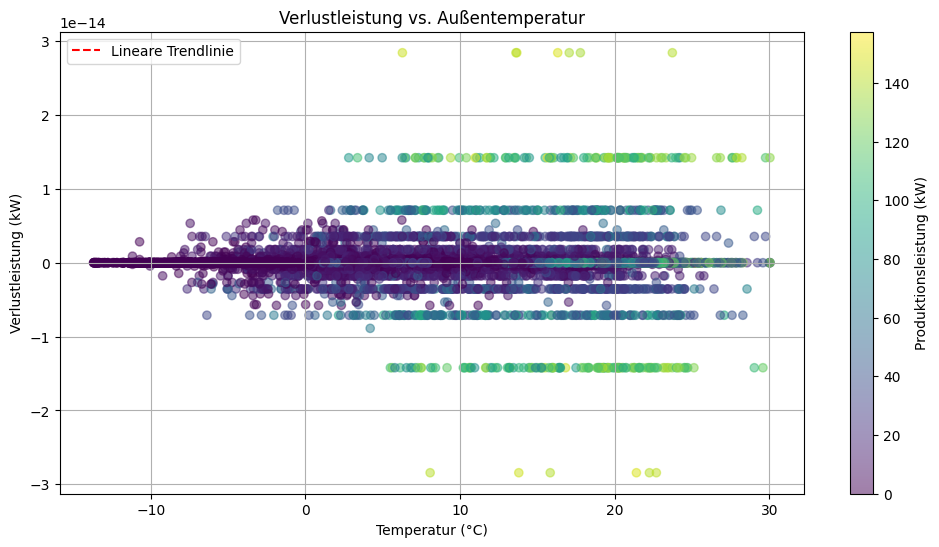


Verlustanalyse nach Temperaturbereich:
            Power_Loss_kW_Mean  Power_Loss_kW_Max  Count  Loss_Ratio_Mean
Temp_Range                                                               
< 0°C                     -0.0                0.0   4208             -0.0
0-10°C                    -0.0                0.0   7080             -0.0
10-20°C                   -0.0                0.0   5174             -0.0
20-30°C                   -0.0                0.0   1054             -0.0
> 30°C                     0.0                0.0      4              0.0


In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Daten einlesen und zusammenführen -----------------------------------
df_a = pd.read_csv('data/A.csv', parse_dates=['Timestamp'])
df_b = pd.read_csv('data/B.csv', parse_dates=['Timestamp'])
df_c = pd.read_csv('data/C.csv', parse_dates=['Timestamp'])

df = pd.concat([df_a, df_b, df_c], ignore_index=True)
df = df.sort_values('Timestamp').reset_index(drop=True)

# --- 2. Power_Loss_kW berechnen ---------------------------------------------
# Power_Loss = Generation - (PV-Selbstverbrauch) - Einspeisung
# PV-Selbstverbrauch = Generation - Grid_Feed-In
# Alternativ über Overall_Consumption_Calc / Grid_Supply:
df['Power_Loss_kW'] = (
      df['Generation_kW']
    - (df['Overall_Consumption_Calc_kW'] - df['Grid_Supply_kW'])
    - df['Grid_Feed-In_kW']
)

# Optional: sehr kleine Werte auf 0 setzen (rundungsbedingt)
# df.loc[df['Power_Loss_kW'].abs() < 1e-6, 'Power_Loss_kW'] = 0

# --- 3. Analyse: Verlustleistung vs. Produktionsleistung --------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Generation_kW', y='Power_Loss_kW', alpha=0.5)

# NaNs rausfiltern
mask = df['Generation_kW'].notna() & df['Power_Loss_kW'].notna()
x = df.loc[mask, 'Generation_kW']
y = df.loc[mask, 'Power_Loss_kW']

# Zentrieren und Skalieren
x_mean, x_std = x.mean(), x.std()
x_scaled = (x - x_mean) / x_std

# Quadratische Trendlinie
coeffs_quad = np.polyfit(x_scaled, y, 2)
poly_quad   = np.poly1d(coeffs_quad)

# Glatte Linie im Originalbereich
x_plot = np.linspace(x.min(), x.max(), 200)
x_plot_scaled = (x_plot - x_mean) / x_std
y_plot = poly_quad(x_plot_scaled)

plt.plot(x_plot, y_plot, 'r--', label='Trendlinie (2. Grades)')
plt.title('Verlustleistung vs. Produktionsleistung')
plt.xlabel('Produktionsleistung (kW)')
plt.ylabel('Verlustleistung (kW)')
plt.legend()
plt.grid(True)
plt.show()

# --- 4. Effizienzquote und Leistungsbereiche -------------------------------
df['Loss_Ratio'] = df['Power_Loss_kW'] / df['Generation_kW']

labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
try:
    df['Power_Range'] = pd.qcut(
        df['Generation_kW'],
        q=5,
        labels=labels,
        duplicates='drop'
    )
except ValueError:
    df['Power_Range'] = pd.cut(
        df['Generation_kW'],
        bins=5,
        labels=labels,
        include_lowest=True
    )

efficiency_analysis = df.groupby('Power_Range', observed=False).agg(
    Loss_Ratio_Mean     = ('Loss_Ratio', 'mean'),
    Generation_kW_Mean  = ('Generation_kW', 'mean'),
    Count               = ('Generation_kW', 'count')
).round(3)

print('\nEffizienzanalyse nach Leistungsbereich:')
print(efficiency_analysis)

# --- 5. Analyse: Verlustleistung vs. Temperatur -----------------------------
try:
    # Korrektes Einlesen der Wetterdaten: Spalte heißt 'time'
    weather_df = pd.read_csv(
        'data/weather_aargau_2019.csv',
        parse_dates=['time']
    )
    weather_df.rename(columns={'time': 'Timestamp'}, inplace=True)

    # Zusammenführen auf Timestamp
    df_merged = pd.merge(df, weather_df, on='Timestamp', how='inner')

    plt.figure(figsize=(12, 6))
    sc = plt.scatter(
        df_merged['temperature'],
        df_merged['Power_Loss_kW'],
        c=df_merged['Generation_kW'],
        cmap='viridis',
        alpha=0.5
    )
    plt.colorbar(sc, label='Produktionsleistung (kW)')

    # Lineare Trendlinie
    coeffs_lin = np.polyfit(df_merged['temperature'], df_merged['Power_Loss_kW'], 1)
    poly_lin   = np.poly1d(coeffs_lin)
    x_temp = np.sort(df_merged['temperature'])
    plt.plot(x_temp, poly_lin(x_temp), 'r--', label='Lineare Trendlinie')

    plt.title('Verlustleistung vs. Außentemperatur')
    plt.xlabel('Temperatur (°C)')
    plt.ylabel('Verlustleistung (kW)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Temperaturbereich-Analyse
    temp_bins   = [-np.inf, 0, 10, 20, 30, np.inf]
    temp_labels = ['< 0°C', '0-10°C', '10-20°C', '20-30°C', '> 30°C']
    df_merged['Temp_Range'] = pd.cut(
        df_merged['temperature'],
        bins=temp_bins,
        labels=temp_labels,
        include_lowest=True
    )

    temp_analysis = df_merged.groupby('Temp_Range', observed=False).agg(
        Power_Loss_kW_Mean = ('Power_Loss_kW', 'mean'),
        Power_Loss_kW_Max  = ('Power_Loss_kW', 'max'),
        Count              = ('Power_Loss_kW', 'count'),
        Loss_Ratio_Mean    = ('Loss_Ratio', 'mean')
    ).round(3)

    print('\nVerlustanalyse nach Temperaturbereich:')
    print(temp_analysis)

except Exception as e:
    print(f'Fehler beim Laden/Verarbeiten der Wetterdaten: {e}')



# Verbrauch auf Tag (Sheena) mit Wetter Daten

In [36]:
import requests
import pandas as pd

# Define the API endpoint and parameters
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 47.3925,
    "longitude": 8.0442,
    "start_date": "2019-01-01",
    "end_date": "2019-12-31",
    "daily": "sunshine_duration,temperature_2m_mean",
    "timezone": "Europe/Zurich"
}

# Make the API request
response = requests.get(url, params=params)
data = response.json()

# Extract data
dates = data['daily']['time']
sunshine = data['daily']['sunshine_duration']  # in seconds
temperature = data['daily']['temperature_2m_mean']  # in °C

# Build DataFrame
df_api_weather = pd.DataFrame({
    'Date': pd.to_datetime(dates),
    'Sunshine Duration (hours)': [round(s / 3600, 2) for s in sunshine],
    'Air Temperature Mean (°C)': temperature
})

# Show first few rows and summary
print(df_api_weather.head())
df_api_weather[['Sunshine Duration (hours)', 'Air Temperature Mean (°C)']].describe()



        Date  Sunshine Duration (hours)  Air Temperature Mean (°C)
0 2019-01-01                       0.80                        3.3
1 2019-01-02                       6.05                        1.5
2 2019-01-03                       7.10                       -2.3
3 2019-01-04                       6.49                       -0.8
4 2019-01-05                       0.00                        0.4


,Sunshine Duration (hours),Air Temperature Mean (°C)
count,365.000000,365.000000
mean,7.791178,10.588493
std,4.547256,7.377306
min,0.000000,-2.800000
25%,4.060000,4.400000
50%,8.340000,10.000000
75%,11.470000,16.400000
max,14.770000,28.000000


Index(['Timestamp', 'Generation_kW', 'Grid_Feed-In_kW', 'Grid_Supply_kW',
       'Overall_Consumption_Calc_kW'],
      dtype='object')


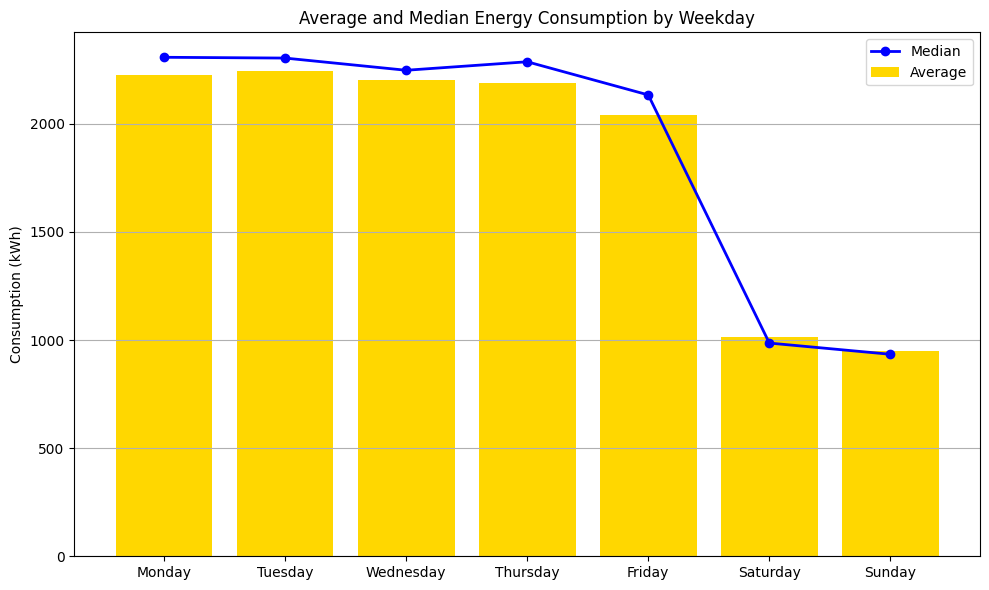

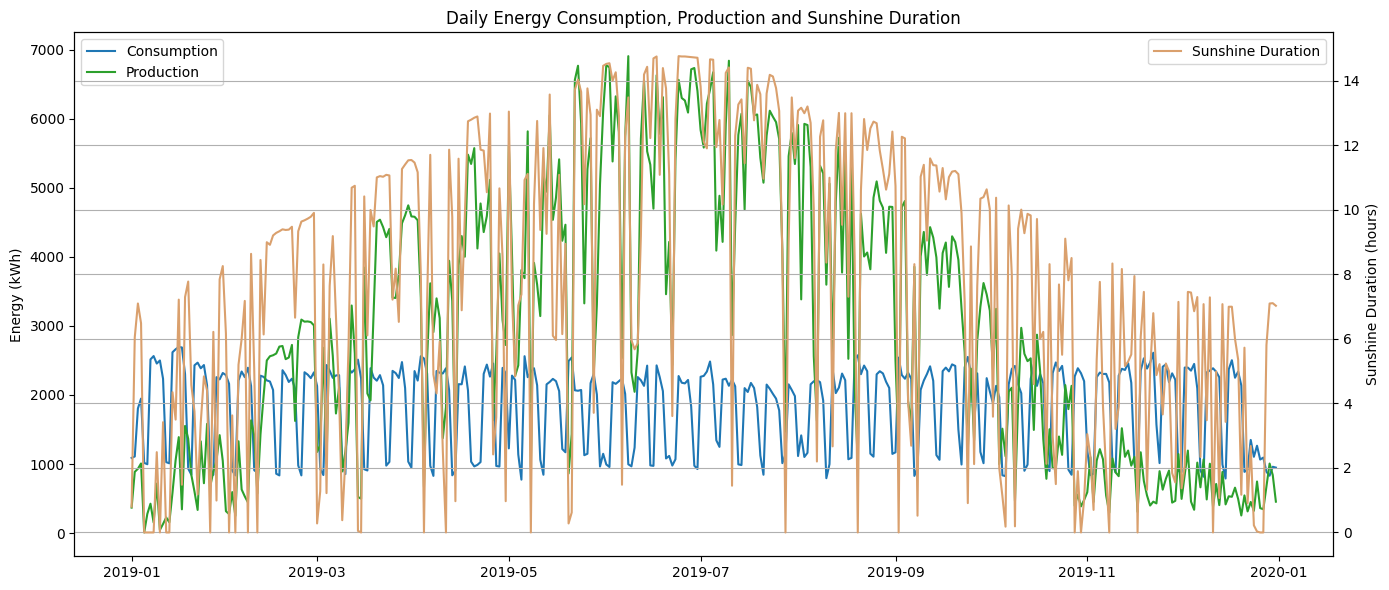

C:\Users\sheen\AppData\Local\Temp\ipykernel_34032\2845725115.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = merged.resample('M').mean(numeric_only=True)


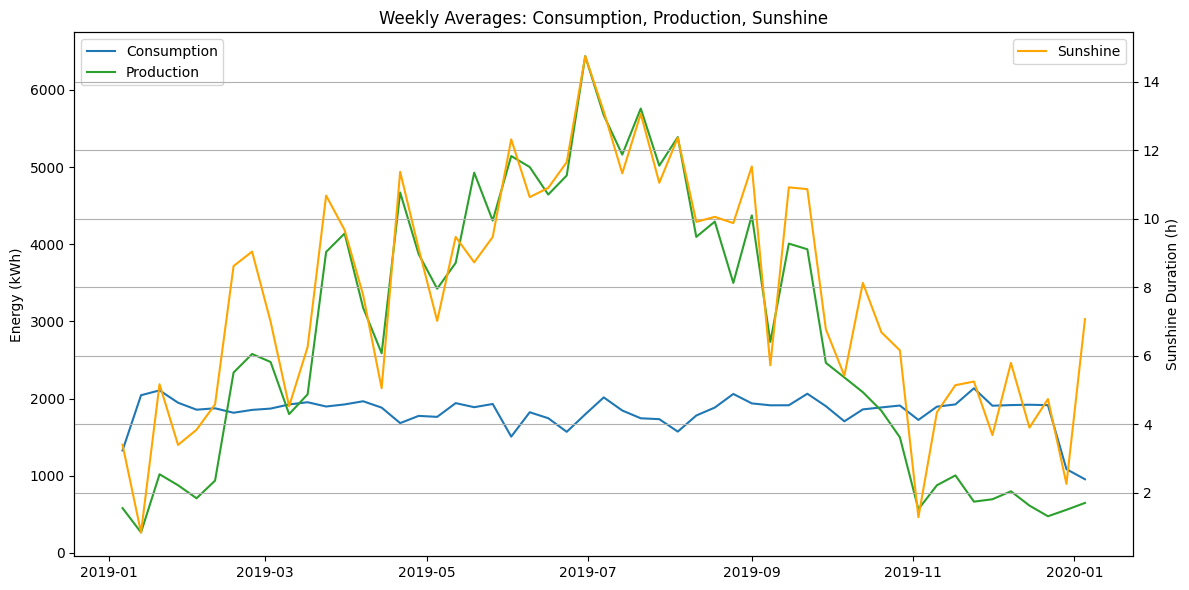

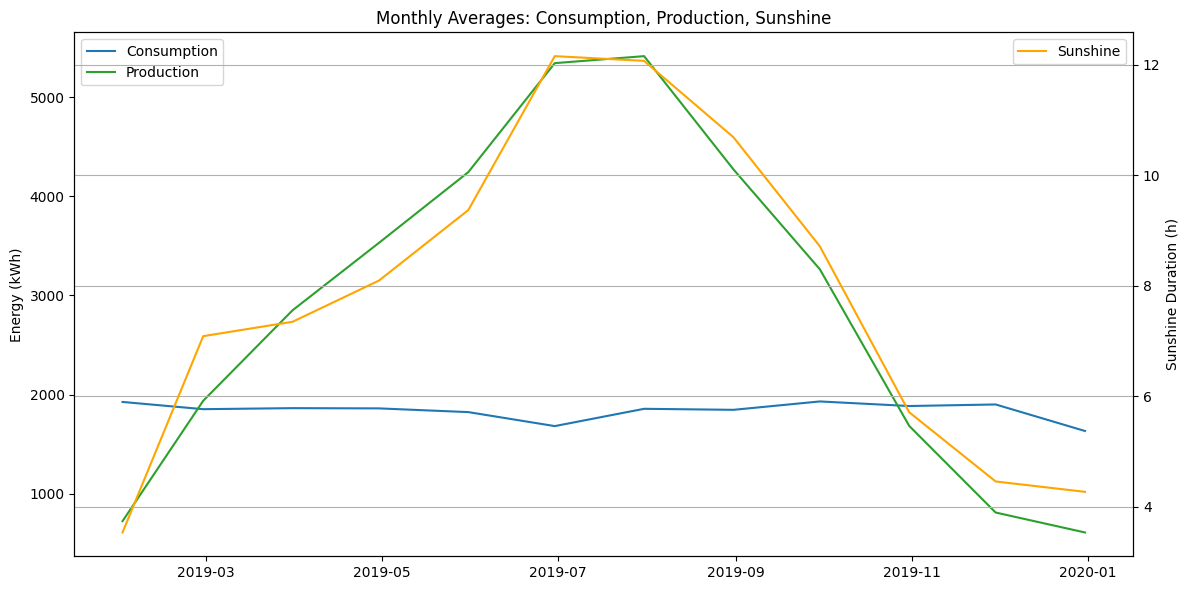

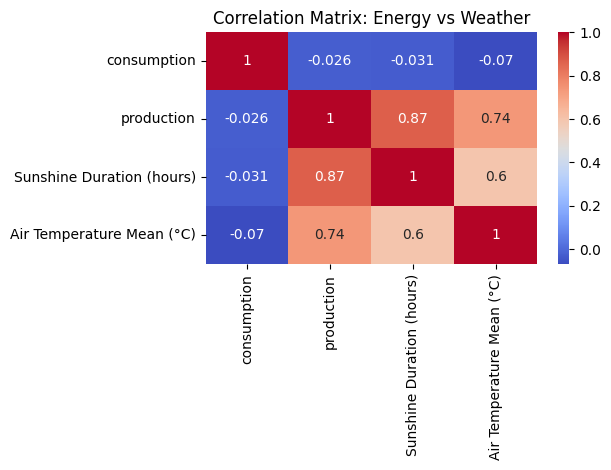

In [64]:
# STEP 1: Copy the merged df and inspect columns
df_energy = df.copy()
print(df_energy.columns)

# STEP 2: Detect and convert timestamp column
timestamp_col = next((col for col in df_energy.columns if col.lower() == 'timestamp'), None)
if timestamp_col is None:
    raise KeyError("No timestamp-like column found in df_energy")

df_energy['timestamp'] = pd.to_datetime(df_energy[timestamp_col])

# STEP 3: Normalize and convert energy columns to numeric
df_energy['consumption'] = pd.to_numeric(
    df_energy.get('Overall_Consumption_Calc_kW', df_energy.get('Grid_Supply_kW')),
    errors='coerce'
)
df_energy['production'] = pd.to_numeric(
    df_energy['Generation_kW'] if 'Generation_KW' in df_energy.columns or 'Generation_kW' in df_energy.columns else 0,
    errors='coerce'
)

df_energy = df_energy[['timestamp', 'consumption', 'production']].dropna()

# STEP 4: Resample to daily
df_energy.set_index('timestamp', inplace=True)
daily_df = df_energy.resample('D').sum()
daily_df['weekday'] = daily_df.index.day_name()

# STEP 5: Weekday analysis
weekday_avg = daily_df.groupby('weekday', observed=True)['consumption'].mean()
weekday_median = daily_df.groupby('weekday', observed=True)['consumption'].median()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg = weekday_avg.reindex(weekday_order)
weekday_median = weekday_median.reindex(weekday_order)

# Plot 1: Weekday consumption
plt.figure(figsize=(10, 6))
plt.bar(weekday_avg.index, weekday_avg.values, color='gold', label='Average')
plt.plot(weekday_median.index, weekday_median.values, color='blue', marker='o', linewidth=2, label='Median')
plt.ylabel("Consumption (kWh)")
plt.title("Average and Median Energy Consumption by Weekday")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# STEP 6: Prepare weather data (df_api_weather)
if 'Date' in df_api_weather.columns:
    df_api_weather['Date'] = pd.to_datetime(df_api_weather['Date'])
    df_api_weather.set_index('Date', inplace=True)
else:
    df_api_weather.index = pd.to_datetime(df_api_weather.index)

# Convert sunshine from seconds to hours if needed
if 'sunshine_duration' in df_api_weather.columns and 'Sunshine Duration (hours)' not in df_api_weather.columns:
    df_api_weather['Sunshine Duration (hours)'] = df_api_weather['sunshine_duration'] / 3600

# Convert both key columns to numeric
df_api_weather['Sunshine Duration (hours)'] = pd.to_numeric(df_api_weather['Sunshine Duration (hours)'], errors='coerce')
df_api_weather['Air Temperature Mean (°C)'] = pd.to_numeric(df_api_weather['Air Temperature Mean (°C)'], errors='coerce')

# Drop raw seconds column (optional)
df_api_weather.drop(columns=['sunshine_duration'], inplace=True, errors='ignore')

# Normalize indexes
daily_df.index = daily_df.index.normalize()
df_api_weather.index = df_api_weather.index.normalize()


# STEP 7: Merge weather and energy data
merged = daily_df.merge(df_api_weather, left_index=True, right_index=True, how='inner')

# Plot 2: Daily
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()
ax1.plot(merged.index, merged['consumption'], label='Consumption', color='tab:blue')
ax1.plot(merged.index, merged['production'], label='Production', color='tab:green')
ax2.plot(merged.index, merged['Sunshine Duration (hours)'], label='Sunshine Duration', color='#DAA06D')

ax1.set_ylabel("Energy (kWh)")
ax2.set_ylabel("Sunshine Duration (hours)")
ax1.set_title("Daily Energy Consumption, Production and Sunshine Duration")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 8: Weekly and Monthly summaries
weekly = merged.resample('W').mean(numeric_only=True)
monthly = merged.resample('M').mean(numeric_only=True)

# Plot 3: Weekly
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(weekly.index, weekly['consumption'], label='Consumption', color='tab:blue')
ax1.plot(weekly.index, weekly['production'], label='Production', color='tab:green')
ax2.plot(weekly.index, weekly['Sunshine Duration (hours)'], label='Sunshine', color='orange')

ax1.set_ylabel("Energy (kWh)")
ax2.set_ylabel("Sunshine Duration (h)")
ax1.set_title("Weekly Averages: Consumption, Production, Sunshine")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 4: Monthly 
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(monthly.index, monthly['consumption'], label='Consumption', color='tab:blue')
ax1.plot(monthly.index, monthly['production'], label='Production', color='tab:green')
ax2.plot(monthly.index, monthly['Sunshine Duration (hours)'], label='Sunshine', color='orange')

ax1.set_ylabel("Energy (kWh)")
ax2.set_ylabel("Sunshine Duration (h)")
ax1.set_title("Monthly Averages: Consumption, Production, Sunshine")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# STEP 9: Correlation 
# Plot 5: Correlation matrix
corr = merged[['consumption', 'production', 'Sunshine Duration (hours)', 'Air Temperature Mean (°C)']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: Energy vs Weather")
plt.tight_layout()
plt.show()


